In [122]:
import torch
from targets import * 
from classifiers import *

In [123]:
class Orbits(Target):
    def __init__(self, number_planets=7, means_target=None, covs_target=None, weights_target=None):
        super().__init__()
        self.number_planets = number_planets
        if means_target is None:
            self.means_target = 2.5 * torch.view_as_real(
                torch.pow(torch.exp(torch.tensor([2j * 3.1415 / number_planets])), torch.arange(0, number_planets)))
        else:
            assert means_target.shape != [self.number_planets, 2], "wrong size of means"
            self.means_target = means_target

        if covs_target is None:
            self.covs_target = 0.04 * torch.eye(2).unsqueeze(0).repeat(number_planets, 1, 1)
        else:
            assert covs_target.shape != [self.number_planets, 2, 2], 'wrong size of covs'
            self.covs_target = covs_target

        if weights_target is None:
            self.weights_target = torch.ones(self.number_planets)
        else:
            assert weights_target.shape != [self.number_planets], 'wrong size of weights'
            self.weights_target = weights_target

    def sample(self, num_samples, joint=False):
        mvn_target = torch.distributions.MultivariateNormal(self.means_target, self.covs_target)
        all_x = mvn_target.sample(num_samples)
        cat = torch.distributions.Categorical(self.weights_target.log().softmax(dim=0))
        pick = cat.sample(num_samples)
        if joint:
            return all_x[range(all_x.shape[0]), pick, :], pick
        else:
            return all_x[range(all_x.shape[0]), pick, :]

    def log_prob(self, x):
        mvn_target = torch.distributions.MultivariateNormal(self.means_target.to(x.device),
                                                            self.covs_target.to(x.device))
        cat = torch.distributions.Categorical(self.weights_target.softmax(dim=0).to(x.device))
        return torch.distributions.MixtureSameFamily(cat, mvn_target).log_prob(x)

In [140]:
target = Orbits(number_planets=3, covs_target = 8*torch.eye(2).unsqueeze(0).repeat(3,1,1), weights_target= torch.tensor([100.,1.,100.]))
samples, labels = target.sample([10000], joint = True)

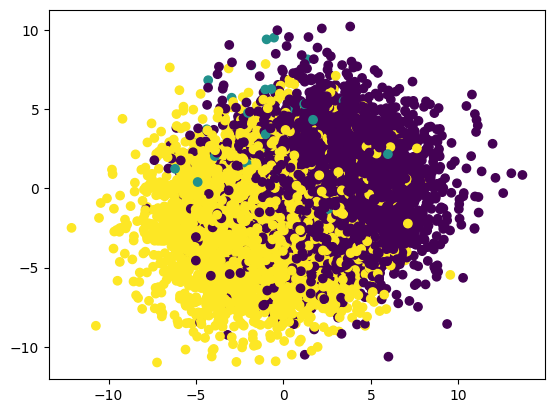

In [141]:
plt.scatter(samples[:,0], samples[:,1], c = labels)

In [142]:
dclass = Classifier(samples, torch.nn.functional.one_hot(labels),[16,16,16])
dclass.train(100,5000, verbose = True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s, loss = 0.5688; device = cpu; train_accuracy = tensor(0.7863)]


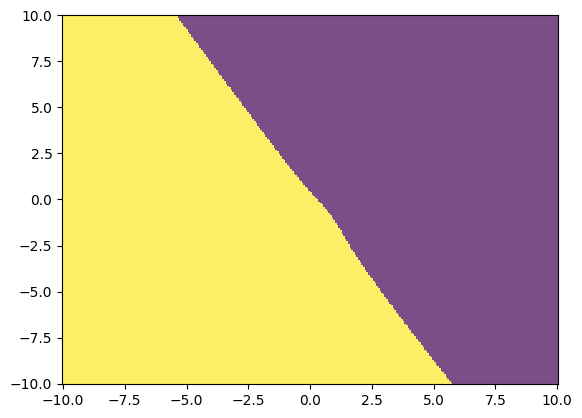

In [134]:
from utils import * 
plot_2d_function(lambda x: torch.argmax(dclass.log_prob(x), dim = -1),range = ((-10,10),(-10,10)), bins = (300,300))

In [135]:
gclass = GenerativeClassifier(samples, torch.nn.functional.one_hot(labels),[16,16,16])
gclass.train(100,5000, verbose = True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s, loss = 0.4857; device = cpu; train_accuracy = tensor(0.7756)]


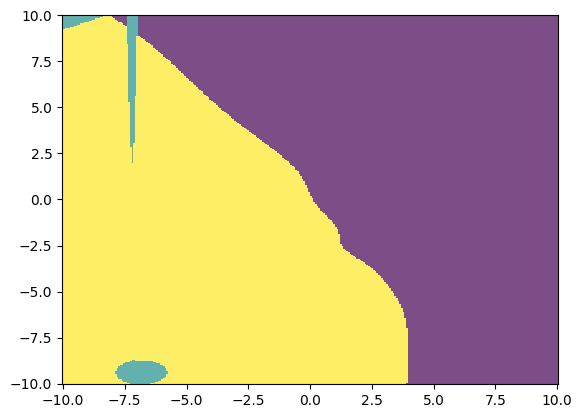

In [136]:
from utils import * 
plot_2d_function(lambda x: torch.argmax(gclass.log_prob(x), dim = -1),range = ((-10,10),(-10,10)), bins = (300,300))